In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## air pollutant concentration

lets study these feild in the data

- timestamp in the index. 

- CO_sensor: carbon monoxide concentration.

- RH: relative humidity (in the air).

In [3]:
filename = "./../../Datasets/AirQualityUCI_ready.csv"

# The variables we will use in this demo:
variables = ["Date_Time", "CO_sensor", "RH"]

df = pd.read_csv(filename, usecols=variables, parse_dates=['Date_Time'])

df.head()

,Date_Time,CO_sensor,RH
0,2004-10-03 18:00:00,1360.0,48.9
1,2004-10-03 19:00:00,1292.0,47.7
2,2004-10-03 20:00:00,1402.0,54.0
3,2004-10-03 21:00:00,1376.0,60.0
4,2004-10-03 22:00:00,1272.0,59.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date_Time  9357 non-null   datetime64[ns]
 1   CO_sensor  9357 non-null   float64       
 2   RH         9357 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 219.4 KB


###  Reduce data span (poor data quality outside these dates)
* `"2004-04-04" : "2005-04-04"`

In [5]:
# set the index
df = df.set_index('Date_Time')

# Reduce data span (poor data quality outside these dates)
df = df.loc['2004-04-04': '2005-04-04']

# sanity check
print('min :',df.index.min(),'max :',df.index.max())


min : 2004-04-04 00:00:00 max : 2005-04-04 14:00:00


### Check for missing data

In [6]:
df.isna().sum()

CO_sensor    0
RH           0
dtype: int64

## Plot the data

In [9]:
plt.figure(figsize=(15,6))
df['CO_sensor'].plot();

<img src="./plots/air-pollution-co-sensor.png">

In [12]:
plt.figure(figsize=(15,6))
df['RH'].plot();

<img src="./plots/air-pollution-rh.png">

## Lets remove the negative values

In [13]:
filter_1 = df['CO_sensor']>=0
filter_2 = df['RH']>=0


data = df[filter_1 & filter_2]
data.head()

,CO_sensor,RH
Date_Time,,
2004-10-03 18:00:00,1360.0,48.9
2004-10-03 19:00:00,1292.0,47.7
2004-10-03 20:00:00,1402.0,54.0
2004-10-03 21:00:00,1376.0,60.0
2004-10-03 22:00:00,1272.0,59.6


In [15]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
data['CO_sensor'].plot();
plt.subplot(2,1,2)
data['RH'].plot();




<img src='./plots/air-pollution-processing.png'>

## Lets Impute the missing values

In [16]:
data.isna().sum()

CO_sensor    0
RH           0
dtype: int64

In [17]:
# first lets introduce the missing time-stamp

data_with_missing_time = data.resample(rule='H').max()
data_with_missing_time.isna().sum()

CO_sensor    1382
RH           1382
dtype: int64

In [18]:
data_with_missing_time[:5]

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


### `asfreq()` Convert time series to specified frequency.

Returns the original data conformed to a new index with the specified frequency.

If the index of this {klass} is a ~pandas.PeriodIndex, the new index is the result of transforming the original index with PeriodIndex.asfreq <pandas.PeriodIndex.asfreq> (so the original index will map one-to-one to the new index).

Otherwise, the new index will be equivalent to pd.date_range(start, end, freq=freq) where start and end are, respectively, the first and last entries in the original index. 

`The values corresponding to any timesteps in the new index which were not present in the original index will be null (NaN), unless a method for filling such unknowns is provided`.

The resample method is more appropriate if an operation on each group of timesteps (such as an aggregate) is necessary to represent the data at the new frequency.


In [19]:
(data.asfreq(freq='H') == data_with_missing_time)[:5]

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,True,True
2004-04-04 01:00:00,True,True
2004-04-04 02:00:00,True,True
2004-04-04 03:00:00,True,True
2004-04-04 04:00:00,True,True


In [20]:
(data.asfreq(freq='H') == data_with_missing_time).value_counts()

CO_sensor  RH   
True       True     7393
False      False    1382
dtype: int64

In [21]:
data_with_missing_time = data.asfreq('1H')

# impute the missing data
data_imputed = data.asfreq(freq='1H').fillna(method='ffill')

### Plot the missing portion

In [23]:
mask = data.asfreq(freq='H').isnull()

plt.figure(figsize=(25, 12))

plt.subplot(211)
data_imputed['CO_sensor'][mask['CO_sensor']].plot(c='r', marker='^', linestyle=' ')

data_with_missing_time['CO_sensor'].plot()

plt.subplot(212)

data_imputed['RH'][mask['RH']].plot(c='r', marker='^', linestyle=' ')

data_with_missing_time['RH'].plot();


<img src="./plots/air-pollution-imputed.png">

## Seasonality

Air pollutant concentration changes with car traffic. At rush hour, we have more pollutants. During the night hours, we have fewer pollutants.

Let's test this hypothesis

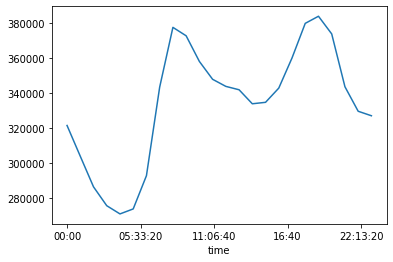

In [20]:
data.groupby(data.index.time).sum()['CO_sensor'].plot();

<AxesSubplot:xlabel='time'>

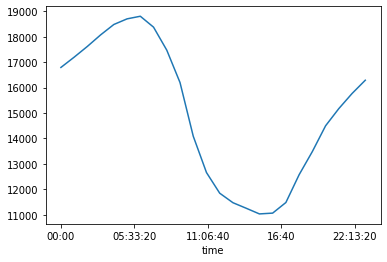

In [21]:
data.groupby(data.index.time).sum()['RH'].plot()